In [1]:
import numpy as np
import neuron
from neuron import h
import os, sys
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import PolyCollection
import subprocess
import pickle, glob
from scipy.signal import chirp 
from scipy.fftpack import fft
from scipy.optimize import leastsq, curve_fit
import re
import scipy.signal
from scipy.signal import find_peaks
import numba
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error , r2_score

import os, subprocess
def svg_to_emf(svg_figpath):
    if True:
        cwd_path = os.getcwd()
        svg_figpath = os.path.join(cwd_path, svg_figpath)
        print(svg_figpath)
    inkscape_path = 'D:\\Pycharm\\Inkscape\\bin\\inkscape.exe' 
    if svg_figpath is not None:
        path, svgfigname = os.path.split(svg_figpath)
        figname, figform = os.path.splitext(svgfigname)
        emf_figpath = os.path.join(path, figname + '.emf')
        subprocess.call("{} {} -T -o {}".format(inkscape_path, svg_figpath, emf_figpath), shell=True)
        # os.remove(svg_figpath)

In [2]:
'''generate EPSP-like synaptic current'''
def generate_epsp_like_current(taur=0.5, taud=5, imax=0.5, onset=320, dt=0.025, tstop=600):
    iepsp = np.zeros(int(tstop/dt))
    tpeak = taur * taud * np.log(taur/taud) / (taur-taud)
    adjust = 1/( (1 - myexp(-tpeak/taur)) - (1 - myexp(-tpeak/taud)) )
    amp = adjust * imax
    for i, t in enumerate(np.arange(0, tstop, dt)):
        if t < onset:
            iepsp[i] = 0.
        else:
            a0 = 1 - myexp(-(t-onset)/taur)
            a1 = 1 - myexp(-(t-onset)/taud)
            iepsp[i] = -amp * (a0 - a1)
    return iepsp

def myexp(x):
    if x < -100:
        return 0
    else:
        return np.exp(x)

@numba.njit
def generatePulseCurrent(amp_pulse=0., tstart=0., tend=0., tvar=np.arange(0, 1, 0.01)):
    index_pulse = np.logical_and(tvar >= tstart, tvar <= tend)
    Ipulse = np.zeros_like(tvar)
    Ipulse[index_pulse] = amp_pulse
    return Ipulse

@numba.njit
def isCalciumSpike(tvar, vdend):
    CaSpike_startVth = -40
    CaSpike_endVth   = -42
    logical_above_startVth = vdend > CaSpike_startVth
    logical_above_endVth   = vdend > CaSpike_endVth
    diff_logical_above_startVth = np.diff(logical_above_startVth)
    diff_logical_above_endVth   = np.diff(logical_above_endVth)
    bool, CaSpike_start_t, CaSpike_end_t = 0, None, None
    if np.any(diff_logical_above_startVth):
        bool = 1
        CaSpike_start_t = tvar[np.where(diff_logical_above_startVth)][0]
        CaSpike_end_t   = tvar[:-1][np.where(diff_logical_above_endVth)][1]
    return bool, CaSpike_start_t, CaSpike_end_t
    
@numba.njit
def calcICaTime(tvar, ICa, ICaVth=-0.03):
    index_below_ICaVth = ICa < ICaVth
    diff_index_below_ICaVth = np.diff(index_below_ICaVth)
    bool, ICa_start_t, ICa_end_t = 0, None, None
    if np.any(diff_index_below_ICaVth):
        bool        = 1
        ICa_start_t = tvar[np.where(diff_index_below_ICaVth)][0]
        ICa_end_t   = tvar[np.where(diff_index_below_ICaVth)][1]
    return bool, ICa_start_t, ICa_end_t

def calcSpikeNumberAndSpikeTime(tvar, vsoma):
    risingBefore = np.hstack((0, vsoma[1:] - vsoma[:-1])) > 0  # v(t)-v(t-1)>0
    fallingAfter = np.hstack((vsoma[1:] - vsoma[:-1], 0)) < 0  # v(t)-v(t+1)<0
    localMaximum = np.logical_and(fallingAfter, risingBefore)
    largerThanThresh = vsoma > 0. 
    binarySpikeVector = np.logical_and(localMaximum,largerThanThresh) 
    spikeInds = np.nonzero(binarySpikeVector)
    spikeNumber = np.sum(binarySpikeVector)
    outputSpikeTimes = tvar[spikeInds]

    return spikeNumber, outputSpikeTimes

In [3]:
class L5PTcell():
    def __init__(self):
        self.init_parameters()
        self.create_cell()
        self.pre_calc_for_plotmorph()
        self.calc_each_segment_vinit()

    def init_parameters(self):
        self.diam_scale_factor = 0  
        self.diam_plus_factor = 2  
        self.subsection_names = ['soma', 'dend', 'apic', 'axon']
        self.subsection_colors = ['k', 'g', 'b', 'r']
        self.somaAtOrigin = False
        self.shiftx, self.shifty, self.shiftz = 0.0, 0.0, 0.0

    def create_cell(self):
        h.load_file('nrngui.hoc')
        h.load_file("import3d.hoc")
        morphologyFilename = "morphologies/cell1.asc"
        biophysicalModelFilename = "L5PCbiophys5b.hoc"
        biophysicalModelTemplateFilename = "L5PCtemplate_2.hoc"
        EfieldFilename = "getes.hoc"

        h.load_file(biophysicalModelFilename)
        h.load_file(biophysicalModelTemplateFilename)
        self.cell = h.L5PCtemplate(morphologyFilename)
        h.load_file("steadystate_init.hoc")
        h.load_file(EfieldFilename)

    def create_SectionLists(self):
        '''Create section lists for different kinds of sections'''
        self.allsecnames = []
        self.allseclists = h.SectionList() 
        for sec in self.cell.all:
            self.allseclists.append(sec=sec)
            self.allsecnames.append(sec.name())
        self.totnsecs = len(self.allsecnames)
        # self.calc_totnsegs()

    def calc_totnsegs(self):
        '''calculate the segment number of all section'''
        self.totnsegs = 0
        for sec in self.allseclists:
            self.totnsegs += sec.nseg
        '''calculate the segment number of each subsection, like soma'''
        # ['soma',  'axon', 'dend', 'apic']
        self.subsection_nsegs = []
        self.each_subsection = []
        self.sec_nseg = []
        num, idx, temp = 0, 0, 0
        num2 = 0
        for sec in self.allseclists:
            self.sec_nseg.append(sec.nseg)
            temp += sec.nseg
            if self.subsection_names[idx] in str(sec):
                num += sec.nseg
                num2 += 1
            else:
                self.subsection_nsegs.append(num)
                self.each_subsection.append(num2)
                num = sec.nseg
                num2 = 1
                idx += 1
            if temp == self.totnsegs:
                self.subsection_nsegs.append(num)
                self.each_subsection.append(num2)
        self.subsection_nsegs_end = []
        for i in range(len(self.subsection_nsegs) + 1):
            self.subsection_nsegs_end.append(sum(self.subsection_nsegs[:i]))

    def calc_eachsection_nsegs(self):
        if not hasattr(self, 'allseclists'):
            self.create_SectionLists()
        '''计算每个section中segment的索引，shape=[nsec, 2], 2代表该section开始和结尾的segment索引'''
        self.each_section_index = np.zeros((len(self.allsecnames), 2))
        secidx, numseg = 0, 0
        for sec in self.allseclists:
            self.each_section_index[secidx, 0] = numseg
            numseg += sec.nseg
            self.each_section_index[secidx, 1] = numseg
            secidx += 1
        self.each_section_index = self.each_section_index.astype(np.int64)

    def collect_geometry(self):
        if not hasattr(self, 'x'):
            # 如果没有定义self.x，则声明变量
            self.x = None
            self.y = None
            self.z = None
            self.area = None
            self.d = None
            self.length = None
        self.collect_geometry_neuron()

    def collect_geometry_neuron(self):
        '''Loop over allseclist to determine area, diam, xyz-start- and endpoints, embed geometry to cell object'''
        areavec = np.zeros(self.totnsegs)
        diamvec = np.zeros(self.totnsegs)
        lengthvec = np.zeros(self.totnsegs)
        xstartvec = np.zeros(self.totnsegs)
        xendvec = np.zeros(self.totnsegs)
        ystartvec = np.zeros(self.totnsegs)
        yendvec = np.zeros(self.totnsegs)
        zstartvec = np.zeros(self.totnsegs)
        zendvec = np.zeros(self.totnsegs)

        counter = 0
        # loop over all segments
        for sec in self.allseclists:
            n3d = int(neuron.h.n3d(sec=sec))  # or int(sec.n3d())
            nseg = sec.nseg  # sec.n3d() > sec.nseg
            gsen2 = 1. / 2 / nseg  
            if n3d > 0:
                # create interpolation objects for the xyz pt3d info:
                L, x, y, z = np.zeros(n3d), np.zeros(n3d), np.zeros(n3d), np.zeros(n3d)
                for i in range(n3d):
                    L[i] = neuron.h.arc3d(i, sec=sec)  # return the length of the first i-th n3d()
                    x[i] = neuron.h.x3d(i, sec=sec)
                    y[i] = neuron.h.y3d(i, sec=sec)
                    z[i] = neuron.h.z3d(i, sec=sec)
                # normalize as seg.x [0, 1]
                L /= sec.L
                # temporary store position of segment midpoints
                segx = np.zeros(nseg)  
                for i, seg in enumerate(sec):
                    segx[i] = seg.x 
                # can't be >0 which may happen due to NEURON->Python float
                # transfer:
                segx0 = (segx - gsen2).round(decimals=6)  
                segx1 = (segx + gsen2).round(decimals=6)  
                # fill vectors with interpolated coordinates of start and end
                # points
                xstartvec[counter:counter + nseg] = np.interp(segx0, L, x)
                xendvec[counter:counter + nseg] = np.interp(segx1, L, x) 
                ystartvec[counter:counter + nseg] = np.interp(segx0, L, y)
                yendvec[counter:counter + nseg] = np.interp(segx1, L, y)
                zstartvec[counter:counter + nseg] = np.interp(segx0, L, z)
                zendvec[counter:counter + nseg] = np.interp(segx1, L, z)
                # fill in values area, diam, length
                for seg in sec:
                    areavec[counter] = neuron.h.area(seg.x, sec=sec)
                    diamvec[counter] = seg.diam
                    lengthvec[counter] = sec.L / nseg
                    counter += 1
        # set cell attributes
        self.x = np.c_[xstartvec, xendvec]
        self.y = np.c_[ystartvec, yendvec]
        self.z = np.c_[zstartvec, zendvec]
        self.area = areavec
        self.d = diamvec * self.diam_scale_factor + self.diam_plus_factor
        self.length = lengthvec

    def get_idx_polygons(self, projection=('x', 'z')):
        '''For each segment idx in cell create a polygon in the plane determined by the projection kwarg (default ('x', 'z'))'''
        ''' example:
        from matplotlib.collections import PolyCollection
        zips = []
        for x, z in self.get_idx_polygons(projection=('x', 'z')):
            zips.append(list(zip(x, z)))
        polycol = PolyCollection(zips, edgecolors='none', facecolors='gray')
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.add_collection(polycol)
        ax.axis(ax.axis('equal'))
        '''
        if len(projection) != 2:
            raise ValueError("projection arg be a tuple like ('x', 'y')")
        if 'x' in projection and 'y' in projection:
            pass
        elif 'x' in projection and 'z' in projection:
            pass
        elif 'y' in projection and 'z' in projection:
            pass
        else:
            mssg = "projection must be a length 2 tuple of 'x', 'y' or 'z'!"
            raise ValueError(mssg)

        polygons = []
        for i in np.arange(self.totnsegs):
            polygons.append(self.create_segment_polygon(i, projection))

        return polygons

    def create_segment_polygon(self, i, projection=('x', 'z')):
        '''Create a polygon to fill for segment i, in the plane determined by kwarg projection'''
        x = getattr(self, projection[0])[i]  # 等同于x = self.x， x[i].shape = (1, 2)
        z = getattr(self, projection[1])[i]
        d = self.d[i]
        # calculate angles
        dx = np.diff(x)
        dz = np.diff(z)
        theta = np.arctan2(dz, dx)[0]
        x = np.r_[x, x[::-1]]  # x=(xstart, xend), x[::-1]=(xend, xstart) →→→ x.shape=(1, 4)
        z = np.r_[z, z[::-1]]
        # 1st corner:
        x[0] -= 0.5 * d * np.sin(theta)
        z[0] += 0.5 * d * np.cos(theta)
        # end of section, first side
        x[1] -= 0.5 * d * np.sin(theta)
        z[1] += 0.5 * d * np.cos(theta)
        # other side
        # end of section, second side
        x[2] += 0.5 * d * np.sin(theta)
        z[2] -= 0.5 * d * np.cos(theta)
        # last corner:
        x[3] += 0.5 * d * np.sin(theta)
        z[3] -= 0.5 * d * np.cos(theta)
        return x, z  # x.shape=y.shape=(1, 4) 矩形四个顶点坐标，顺时针方向

    def make_soma_at_origin(self, somaAtOrigin=True):
        if somaAtOrigin == True:
            self.shiftx = np.mean(self.x[0])
            self.shifty = np.mean(self.y[0])
            self.shiftz = np.mean(self.z[0])
            self.x = self.x - self.shiftx
            self.y = self.y - self.shifty
            self.z = self.z - self.shiftz
        elif somaAtOrigin == False:
            self.shiftx, self.shifty, self.shiftz = 0.0, 0.0, 0.0

    def get_section_coordinate(self, sec, xin, projection=('x', 'y')):
        n3d = int(neuron.h.n3d(sec=sec))
        nseg = sec.nseg
        gsen2 = 1. / 2 / nseg
        if n3d > 0:
            L, x, y, z = np.zeros(n3d), np.zeros(n3d), np.zeros(n3d), np.zeros(n3d)
            for i in range(n3d):
                L[i] = neuron.h.arc3d(i, sec=sec)
                x[i] = neuron.h.x3d(i, sec=sec)
                y[i] = neuron.h.y3d(i, sec=sec)
                z[i] = neuron.h.z3d(i, sec=sec)
            L /= sec.L
            sec_x = np.interp(xin, L, x) - self.shiftx
            sec_y = np.interp(xin, L, y) - self.shifty
            sec_z = np.interp(xin, L, z) - self.shiftz
            coordinate = {'x': sec_x, 'y': sec_y, 'z': sec_z}
        return np.array([coordinate[projection[0]], coordinate[projection[1]]])

    def pre_calc_for_plotmorph(self, projection=('x', 'y')):
        if not hasattr(self, 'allsecnames'):
            self.create_SectionLists()
        self.calc_totnsegs()
        self.collect_geometry()
        self.make_soma_at_origin(somaAtOrigin=self.somaAtOrigin)
        self.calc_eachsection_nsegs()
        self.morph_zips = []
        for x, y in self.get_idx_polygons(projection=projection):
            self.morph_zips.append(list(zip(x, y)))

    def plot_neuron_morphology(self, ax, morph_zips, ec='none', fc='k'):
        from matplotlib.collections import PolyCollection
        polycol = PolyCollection(list(morph_zips), edgecolors=ec, facecolors=fc)
        ax.add_collection(polycol)

    def create_recordings_allseg(self, dt=0.025):
        if not hasattr(self, 'totnsegs'):
            self.totnsegs = 0
            for sec in self.cell.all:
                self.totnsegs += sec.nseg
        self.allseg_recordings = {}
        num = 0
        for sec in self.cell.all:
            for seg in sec:
                self.allseg_recordings['voltage_segment_%d' % num] = neuron.h.Vector().record(sec(seg.x)._ref_v, dt)
                num += 1

    def get_all_segment_voltage(self):
        '''return the membrane voltage of each segment'''
        len_t = len(self.allseg_recordings[list(self.allseg_recordings.keys())[0]].as_numpy().copy())
        voltage_segment = np.zeros((self.totnsegs, len_t))
        list_keys = list(self.allseg_recordings.keys())
        for i in range(len(list_keys)):
            voltage_segment[i, :] = self.allseg_recordings[list_keys[i]].as_numpy().copy()
        return voltage_segment

    def get_segment_init_voltage(self):
        if not hasattr(self, 'allseg_resting_voltage'):
            dt = 0.025
            h.celsius = 34
            h.dt = dt
            h.tstop = 2e3
            neuron.h.stdinit()
            neuron.h.cvode_active(0)
            neuron.h.run()
            segvoltage = self.get_all_segment_voltage()
            self.allseg_resting_voltage = segvoltage[:, -1]
            np.save('data/allseg_resting_voltage.npy', self.allseg_resting_voltage)

    def calc_each_segment_vinit(self):
        if not os.path.exists('data/allseg_resting_voltage.npy'):
            self.create_recordings_allseg()
            self.get_segment_init_voltage()
        self.allseg_resting_voltage = np.load('data/allseg_resting_voltage.npy')  # shape=(706,)
        self.segment_init_vm = []
        idx = 0
        for sec in h.allsec():
            nseg = sec.nseg
            temp = self.allseg_resting_voltage[idx:idx + nseg]
            self.segment_init_vm += [temp[0]] + temp.tolist() + [temp[-1]]
            idx += nseg
        self.segment_init_vm = np.array(self.segment_init_vm)

    def add_recordings(self, secname='apic', secidx=0, x=0.5):
        if not hasattr(self, 'recordings'):
            self.recordings = {}
        if 't' not in list(self.recordings.keys()):
            self.recordings['t'] = h.Vector().record(h._ref_t)
        tempname = secname + '[' + str(secidx) + ']' + '(' + str(x) + ')'
        if secname == 'soma':
            self.recordings[tempname] = h.Vector().record(self.cell.soma[secidx](x)._ref_v)
        elif secname == 'apic':
            self.recordings[tempname] = h.Vector().record(self.cell.apic[secidx](x)._ref_v)
        elif secname == 'dend':
            self.recordings[tempname] = h.Vector().record(self.cell.dend[secidx](x)._ref_v)
        elif secname == 'axon':
            self.recordings[tempname] = h.Vector().record(self.cell.axon[secidx](x)._ref_v)

    def run_simulation_EF(self, Evar=0., tvar=0., dt=0.025, duration=0., theta=90, phi=90):
        '''Simulation'''
        h.calcesE(theta, phi)
        h.dt = dt
        h.tstop = duration
        h.setstim_snowp()
        h.stim_amp.from_python(Evar)
        h.stim_time.from_python(tvar)
        h.attach_stim()
        # neuron.h.stdinit()
        # neuron.h.cvode_active(0)
        neuron.h.run()
        
cell = L5PTcell()

845.34678 
845.34678 


# 1. plot neuron morphology

Text(0, 0.5, 'y-axis (μm)')

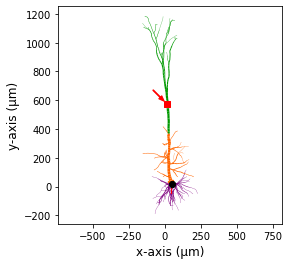

In [4]:
'''soma（idx=0:1）、basal(idx=1:263)、oblique(263:367, 560:640)、apical(367:560), axon(640:642)'''
plot_synapse = True
cell.somaAtOrigin = False
cell.diam_scale_factor = 6
cell.diam_plus_factor  = 0
cell.pre_calc_for_plotmorph()

idx_plot = np.array([0, 1, 1, 263, 263, 367, 367, 560, 560, 640, 640, 642])
idx_plot = idx_plot.reshape(-1, 2)   # shape = (2, 6)
color_plot = ['k', 'purple', '#FF6600', '#009900', '#FF6600', 'r']
fig = plt.figure(figsize=(4, 4))
ax  = fig.add_subplot(111)
for i in range(1, len(color_plot)):
    idx0, idx1 = idx_plot[i]
    polycol = PolyCollection(list(cell.morph_zips)[idx0:idx1], edgecolors='none', facecolors=color_plot[i])
    ax.add_collection(polycol)
if True:
    xy_soma = cell.get_section_coordinate(cell.cell.soma[0], 0.5, projection=('x', 'y'))
    ax.scatter(xy_soma[0], xy_soma[1], marker='o', s=40, color='k')
if plot_synapse == True:
    xy_synapse = cell.get_section_coordinate(cell.cell.apic[36], 0.9, projection=('x', 'y'))
    ax.scatter(xy_synapse[0], xy_synapse[1], marker='s', s=40, color='r')
    ax.arrow(x=xy_synapse[0]-100, y=xy_synapse[1]+100, dx=50, dy=-50, color='r', width=5, head_width=30, head_length=40)
ax.axis('equal')
ax.set_xlabel('x-axis (μm)', fontsize=12)
ax.set_ylabel('y-axis (μm)', fontsize=12)

# 2. Adding synaptic input and recodings

In [5]:
'''EPSP-like current input at the disatl dendrite'''
Id_Apic36_9 = h.IClamp(cell.cell.apic[36](0.9))
Id_Apic36_9.delay = 0
Id_Apic36_9.dur   = 1e9
Id_Apic36_9.amp   = 0
'''somatic input'''
Is_Soma0_5 = h.IClamp(cell.cell.soma[0](0.5))
Is_Soma0_5.delay = 0
Is_Soma0_5.dur   = 1e9
Is_Soma0_5.amp   = 0
'''record the membrane voltages at the soma and nexus'''
cell.add_recordings(secname='soma', secidx=0, x=0.5)
cell.add_recordings(secname='apic', secidx=36, x=0.9)
'''record the synaptic current and Ca2+ current'''
cell.recordings['Id_Apic36_9'] = h.Vector().record(Id_Apic36_9._ref_i)
cell.recordings['Is_Soma0_5']  = h.Vector().record(Is_Soma0_5._ref_i)
cell.recordings['ICa']         = h.Vector().record(cell.cell.apic[36](0.9).ca_ion._ref_ica)

recordingsKeysList = list(cell.recordings.keys())
print(cell.recordings.keys())

dict_keys(['t', 'soma[0](0.5)', 'apic[36](0.9)', 'Id_Apic36_9', 'Is_Soma0_5', 'ICa'])


In [6]:
'''run simulation at given Imax, Tde, Vds, Etheta, DEL, DUR, dt'''
def run_simulation_at_a_given_condition(Imax=0., Tde=20.0, Vds=0., Etheta=90, DEL=510, DUR=140, dt=0.025):
    dt       = 0.025
    tstop    = DEL + DUR + 0
    tvar     = np.arange(0, tstop, dt)
    # EF waveform
    Evar_DEL   = np.zeros_like(np.arange(0, DEL, dt))
    Evar_DUR   = Vds + np.zeros_like(np.arange(0, DUR, dt))
    Evar_tstop = np.zeros_like(np.arange(0, tstop - DEL - DUR, dt))
    Evar       = np.hstack((Evar_DEL, Evar_DUR, Evar_tstop))
    # synaptic input
    Iepsp     = - generate_epsp_like_current(taur=0.5, taud=5, imax=Imax, onset=DEL + Tde, dt=dt, tstop=tstop)
    tvar_hoc  = h.Vector().from_python(tvar)
    Iepsp_hoc = h.Vector().from_python(Iepsp)
    Iepsp_hoc.play(Id_Apic36_9._ref_amp, tvar_hoc, True)
    Is_Soma0_5.delay = 0.0
    Is_Soma0_5.dur   = 1e9
    Is_Soma0_5.amp   = 0.0
    # run simulation 
    cell.run_simulation_EF(Evar=Evar, tvar=tvar, dt=dt, duration=tstop, theta=Etheta, phi=90)
    # extract the simulation results
    idx1, idx2 = 25, int(tstop / dt)
    t     = cell.recordings['t'].to_python()[idx1:idx2]
    vsoma = cell.recordings['soma[0](0.5)'].to_python()[idx1:idx2]
    vdend = cell.recordings['apic[36](0.9)'].to_python()[idx1:idx2]
    ICa   = cell.recordings['ICa'].to_python()[idx1:idx2]
    Is    = cell.recordings['Is_Soma0_5'].to_python()[idx1:idx2]
    Id    = cell.recordings['Id_Apic36_9'].to_python()[idx1:idx2]
    t, vsoma, vdend = np.array(t), np.array(vsoma), np.array(vdend)
    Is, Id, ICa     = np.array(Is), np.array(Id), np.array(ICa)

    return t, vsoma, vdend, Id, Is, tvar, Evar

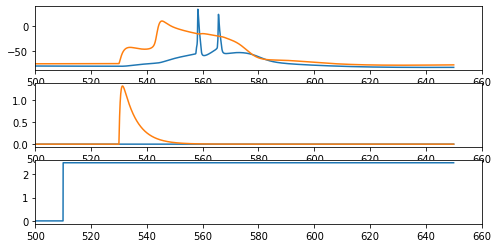

In [8]:
'''example'''
Imax, Tde   = 1.32, 20
Vds, Etheta = 2.5, 90
DEL, DUR    = 510, 140
t, vsoma, vdend, Id, Is, tvar, Evar = run_simulation_at_a_given_condition(
                                    Imax=Imax, Tde=Tde, Vds=Vds, Etheta=Etheta, DEL=DEL, DUR=DUR)

fig, ax = plt.subplots(3, 1, figsize=(8, 4))
ax[0].plot(t, vsoma)
ax[0].plot(t, vdend)
ax[1].plot(t, Is)
ax[1].plot(t, Id)
ax[2].plot(tvar, Evar)
for i in range(3):
    ax[i].set_xlim(500, DEL+DUR+10)

# 3. Figure 7(b): 1.32 nA

In [ ]:
%%time
list_Vds = [-5, 0, 5]
list_vsoma, list_vdend, list_ICa = [], [], []
list_CaTs, list_CaTe, list_CaDuration = [], [], []
for amp_dc in list_Vds:
    dt       = 0.025
    DEL, DUR = 510, 150-10
    tstop    = DEL + DUR + 0
    tvar     = np.arange(0, tstop, dt)
    
    AMP_AC, FREQ = 0., 10
    AMP_DC       = amp_dc
    Evar_DEL     = np.zeros_like(np.arange(0, DEL, dt))
    Evar_DUR     = AMP_DC + AMP_AC*np.sin(2*np.pi*FREQ*np.arange(0, DUR, dt)/1000)
    Evar_tstop   = np.zeros_like(np.arange(0, tstop - DEL - DUR, dt))
    Evar         = np.hstack((Evar_DEL, Evar_DUR, Evar_tstop))

    Iepsp     = - generate_epsp_like_current(taur=0.5, taud=5, imax=1.32, onset=530, dt=dt, tstop=tstop)
    tvar_hoc  = h.Vector().from_python(tvar)
    Iepsp_hoc = h.Vector().from_python(Iepsp)
    Iepsp_hoc.play(Id_Apic36_9._ref_amp, tvar_hoc, True)
    Is_Soma0_5.delay  = 500
    Is_Soma0_5.dur    = 1e9
    Is_Soma0_5.amp    = 0

    cell.run_simulation_EF(Evar=Evar, tvar=tvar, dt=dt, duration=tstop, theta=90, phi=90)

    idx1, idx2 = 25, int(tstop/dt)
    t      = cell.recordings['t'].to_python()[idx1:idx2]
    vsoma  = cell.recordings['soma[0](0.5)'].to_python()[idx1:idx2]
    vdend  = cell.recordings['apic[36](0.9)'].to_python()[idx1:idx2]
    Id     = cell.recordings['Id_Apic36_9'].to_python()[idx1:idx2]
    Is     = cell.recordings['Is_Soma0_5'].to_python()[idx1:idx2]
    ICa    = cell.recordings['ICa'].to_python()[idx1:idx2]
    t, vsoma, vdend, ICa = np.array(t), np.array(vsoma), np.array(vdend), np.array(ICa)
    list_vsoma.append(vsoma)
    list_vdend.append(vdend)
    list_ICa.append(ICa)
    boolCaSpike, ts, te = isCalciumSpike(tvar, vdend)
    if boolCaSpike == 1:
        list_CaTs.append(ts)
        list_CaTe.append(te)
        list_CaDuration.append(te-ts)
    else:
        list_CaTs.append(0)
        list_CaTe.append(0)
        list_CaDuration.append(0)

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(parent_dir, 'data')
np.savez(os.path.join(data_dir, 'vsvd_E5mVmm_tde20ms_Imax1.32nA_HayModel.npz'), t=t, vsoma=list_vsoma, vdend=list_vdend, Iepsp=Id)

# 4. Figure 7(e): 1.6 nA

In [ ]:
%%time
list_Vds = [-5, 0, 5]
list_vsoma, list_vdend, list_ICa = [], [], []
list_CaTs, list_CaTe, list_CaDuration = [], [], []
for amp_dc in list_Vds:
    dt       = 0.025
    DEL, DUR = 510, 150-10
    tstop    = DEL + DUR + 0
    tvar     = np.arange(0, tstop, dt)

    AMP_AC, FREQ = 0., 10
    AMP_DC       = amp_dc
    Evar_DEL     = np.zeros_like(np.arange(0, DEL, dt))
    Evar_DUR     = AMP_DC + AMP_AC*np.sin(2*np.pi*FREQ*np.arange(0, DUR, dt)/1000)
    Evar_tstop   = np.zeros_like(np.arange(0, tstop - DEL - DUR, dt))
    Evar         = np.hstack((Evar_DEL, Evar_DUR, Evar_tstop))

    Iepsp     = - generate_epsp_like_current(taur=0.5, taud=5, imax=1.6, onset=530, dt=dt, tstop=tstop)
    tvar_hoc  = h.Vector().from_python(tvar)
    Iepsp_hoc = h.Vector().from_python(Iepsp)
    Iepsp_hoc.play(Id_Apic36_9._ref_amp, tvar_hoc, True)
    Is_Soma0_5.delay  = 500
    Is_Soma0_5.dur    = 1e9
    Is_Soma0_5.amp    = 0

    cell.run_simulation_EF(Evar=Evar, tvar=tvar, dt=dt, duration=tstop, theta=90, phi=90)

    idx1, idx2 = 25, int(tstop/dt)
    t      = cell.recordings['t'].to_python()[idx1:idx2]
    vsoma  = cell.recordings['soma[0](0.5)'].to_python()[idx1:idx2]
    vdend  = cell.recordings['apic[36](0.9)'].to_python()[idx1:idx2]
    Id     = cell.recordings['Id_Apic36_9'].to_python()[idx1:idx2]
    Is     = cell.recordings['Is_Soma0_5'].to_python()[idx1:idx2]
    ICa    = cell.recordings['ICa'].to_python()[idx1:idx2]
    t, vsoma, vdend, ICa = np.array(t), np.array(vsoma), np.array(vdend), np.array(ICa)
    list_vsoma.append(vsoma)
    list_vdend.append(vdend)
    list_ICa.append(ICa)
    boolCaSpike, ts, te = isCalciumSpike(tvar, vdend)
    if boolCaSpike == 1:
        list_CaTs.append(ts)
        list_CaTe.append(te)
        list_CaDuration.append(te-ts)
    else:
        list_CaTs.append(0)
        list_CaTe.append(0)
        list_CaDuration.append(0)

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(parent_dir, 'data')
np.savez(os.path.join(data_dir, 'vsvd_E5mVmm_tde20ms_Imax1.6nA_HayModel.npz'), t=t, vsoma=list_vsoma, vdend=list_vdend, Iepsp=Id)